# Overview
This notebook identifies significant r values
* fisherZ correct
* stack across participants and runs
* run t-test and identify r values greater than 0
* reconvert fisherZ back to correlation coefficients
* stack coefficients across hemisphere for multiple comparisons
* save results in corresponding hemisphere while preserving medial/non-medial wall vertices

### modules

In [1]:
import numpy as np
import pandas as pd
import os
from os.path import join
import scipy.stats
from statsmodels.stats.multitest import multipletests
import nibabel as nib
from pathlib import Path

### function: write_gifti

In [2]:
def write_gifti(data, output_fn, template_fn):
    gii = nib.load(template_fn)
    for i in np.arange(gii.numDA):
        gii.remove_gifti_data_array(0)
    gda = nib.gifti.GiftiDataArray(data)
    gii.add_gifti_data_array(gda)
    nib.gifti.giftiio.write(gii, output_fn)

### parameters

In [2]:
suma_dir = '/Users/h/suma-fsaverage6'
main_dir = '/dartfs/rc/lab/D/DBIC/DBIC/f0042x1/life-encoding'
main_dir = '/Volumes/life-encoding'
# output_dir = os.path.join(main_dir, 'results', 'himalaya', 'pca', 'ha_common_pca-40')
output_dir = os.path.join(main_dir, 'results', 'himalaya', 'moten', 'ha_common_pca-40')
alignment = 'ha_common'
results = ['bg-r', 'actions-r',  'agents-r', 'moten-r']
runs = [1, 2, 3, 4]
hemis = ['lh', 'rh']
fmri_durs = {1: 374, 2: 346, 3: 377, 4: 412}
n_samples = 1509
n_vertices = 40962
n_medial = {'lh': 3486, 'rh': 3491}
subjects = ['sub-rid000001', 'sub-rid000005', 'sub-rid000006',
            'sub-rid000009', 'sub-rid000012', 'sub-rid000014',
            'sub-rid000017', 'sub-rid000019', 'sub-rid000024',
            'sub-rid000027', 'sub-rid000031', 'sub-rid000032',
            'sub-rid000033', 'sub-rid000034', 'sub-rid000036',
            'sub-rid000037', 'sub-rid000038', 'sub-rid000041']



In [20]:
for result in results:
    hemi_t = []
    hemi_p = []
    hemi_mean = []
    print(f"starting {result} ________________")
    for hemisphere in hemis:
        medial_mask = np.load(os.path.join(main_dir, 'data', f'fsaverage6_medial_{hemisphere}.npy'))
        assert np.sum(medial_mask) == n_medial[hemisphere]
        cortical_vertices = ~medial_mask # boolean (true for non-medials, false for medials)
        cortical_coords = np.where(cortical_vertices)[0] # returns indices of non-medials
        avg_all = []
        # NOTE 1. Fisher z transform per run per participant (np.arctanh)
        for test_subject in subjects:
            stack_fisherz_run = []
            for test_run in runs:           
                run_data = np.load(f"{output_dir}/{result}_align-{alignment}_{test_subject}_run-{test_run}_hemi-{hemisphere}.npy")
                fisherz_run = np.arctanh(run_data[0, cortical_vertices])
                stack_fisherz_run.append(fisherz_run)
        
            # NOTE: 2. average (z-transformed) correlations across runs: yields 18 maps (1 per subject)
            avg_run = np.mean(np.vstack(stack_fisherz_run), axis = 0)
            avg_all.append(avg_run)
        fisherz_all = np.vstack(avg_all) # 18 x nonmedial (per hemi)

        # NOTE: 3. Scipy ttest_1samp to get t-value and p-value
        t, p = scipy.stats.ttest_1samp(fisherz_all, popmean=0,axis=0, alternative='greater')
        hemi_t.append(t)
        hemi_p.append(p)
        hemi_mean.append(np.tanh(np.nanmean(fisherz_all, axis = 0)))

    # %% NOTE: 4-1. concatenate (np.hstack) the two hemispheres p-values (and exclude medial wall) prior to computing FDR (load in cortical_vertices.npy)
    left_vert = hemi_p[0].shape[0]
    t_all = np.hstack(hemi_t)
    p_all = np.hstack(hemi_p)

    reject, q_all, _, _ = multipletests(p_all, method = 'fdr_bh')
    q_both = [q_all[:left_vert], q_all[left_vert:]]
    print("* completed t-tests for both hemispheres")
    hemilabels = ['lh', 'rh']
    Path(join(output_dir, 'stats')).mkdir(parents = True, exist_ok = True)
    for h, hemisphere in enumerate(hemis):
        stats = np.zeros((n_vertices))
        hemi_mean[h][q_both[h] >= .05] = 0
        medial_mask = np.load(os.path.join(main_dir, 'data', f'fsaverage6_medial_{hemisphere}.npy'))
        assert np.sum(medial_mask) == n_medial[hemisphere]
        cortical_vertices = ~medial_mask # boolean (true for non-medials, false for medials)
        cortical_coords = np.where(cortical_vertices)[0] # returns indices of non-medials
        stats[cortical_coords] = hemi_mean[h]
        save_fname = f"{output_dir}/stats/{result}_align-{alignment}_hemi-{hemisphere}_ttest.gii"
        write_gifti(stats.astype(float),
        template_fn = os.path.join(suma_dir, f"{hemilabels[h]}.pial.gii"), 
        output_fn = save_fname)
    print("* saved output (thresholded average r) for both hemispheres")


starting bg-r ________________
* completed t-tests for both hemispheres
* saved output (thresholded average r) for both hemispheres
starting actions-r ________________


/var/folders/w8/z3vy42z17hq5gc9r_5hzsgxw0000gn/T/ipykernel_19721/2446651520.py:7: DeprecationWarning: giftiio.write function deprecated. Use nibabel.load() instead.

* deprecated from version: 2.1
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 4.0
  nib.gifti.giftiio.write(gii, output_fn)


* completed t-tests for both hemispheres
* saved output (thresholded average r) for both hemispheres
starting agents-r ________________
* completed t-tests for both hemispheres
* saved output (thresholded average r) for both hemispheres


# contrasts

In [53]:
from itertools import combinations
results = ['actions-r', 'bg-r',  'agents-r']
pairs = list(combinations(results, 2))

In [54]:
pairs

[('actions-r', 'bg-r'), ('actions-r', 'agents-r'), ('bg-r', 'agents-r')]

In [56]:

for p1, p2 in pairs:
    hemi_t = []
    hemi_p = []
    hemi_mean = []
    print(f"starting {p1} {p2}________________")
    for hemisphere in hemis:
        medial_mask = np.load(os.path.join(main_dir, 'data', f'fsaverage6_medial_{hemisphere}.npy'))
        assert np.sum(medial_mask) == n_medial[hemisphere]
        cortical_vertices = ~medial_mask # boolean (true for non-medials, false for medials)
        cortical_coords = np.where(cortical_vertices)[0] # returns indices of non-medials
        avg_all = []
        
        # NOTE 1. Fisher z transform per run per participant (np.arctanh)
        for test_subject in subjects:
            stack_fisherz_p1run = []
            stack_fisherz_p2run = []
            # stack_p1run = []
            # stack_p2run = []
            for test_run in runs:           
                p1_data = np.load(f"{output_dir}/{p1}_align-{alignment}_{test_subject}_run-{test_run}_hemi-{hemisphere}.npy")
                fisherz_p1run = np.arctanh(p1_data[0, cortical_vertices])
                stack_fisherz_p1run.append(fisherz_p1run)

                p2_data = np.load(f"{output_dir}/{p2}_align-{alignment}_{test_subject}_run-{test_run}_hemi-{hemisphere}.npy")
                fisherz_p2run = np.arctanh(p2_data[0, cortical_vertices])
                stack_fisherz_p2run.append(fisherz_p2run)
        
            # NOTE: 2. average (z-transformed) correlations across runs: yields 18 maps (1 per subject)
            # avg_run = np.mean(np.vstack(stack_fisherz_run), axis = 0)
            stack_p1run = np.vstack(stack_fisherz_p1run)
            stack_p2run = np.vstack(stack_fisherz_p2run)
            diff = stack_p1run - stack_p2run
            # print(stack_run.shape)
            # raise
            avg_run = np.mean(diff, axis = 0)
            avg_all.append(avg_run)
        fisherz_all = np.vstack(avg_all) # 18 x nonmedial (per hemi)

        # NOTE: 3. Scipy ttest_1samp to get t-value and p-value
        t, p = scipy.stats.ttest_1samp(fisherz_all, popmean=0,axis=0, alternative='two-sided')
        hemi_t.append(t)
        hemi_p.append(p)
        hemi_mean.append(np.tanh(np.nanmean(fisherz_all, axis = 0)))

    # %% NOTE: 4-1. concatenate (np.hstack) the two hemispheres p-values (and exclude medial wall) prior to computing FDR (load in cortical_vertices.npy)
    left_vert = hemi_p[0].shape[0]
    t_all = np.hstack(hemi_t)
    p_all = np.hstack(hemi_p)

    reject, q_all, _, _ = multipletests(p_all, method = 'fdr_bh')
    q_both = [q_all[:left_vert], q_all[left_vert:]]
    print("* completed t-tests for both hemispheres")
    hemilabels = ['lh', 'rh']
    Path(join(output_dir, 'stats')).mkdir(parents = True, exist_ok = True)
    for h, hemisphere in enumerate(hemis):
        stats = np.zeros((n_vertices))
        hemi_mean[h][q_both[h] >= .05] = 0
        medial_mask = np.load(os.path.join(main_dir, 'data', f'fsaverage6_medial_{hemisphere}.npy'))
        assert np.sum(medial_mask) == n_medial[hemisphere]
        cortical_vertices = ~medial_mask # boolean (true for non-medials, false for medials)
        cortical_coords = np.where(cortical_vertices)[0] # returns indices of non-medials
        stats[cortical_coords] = hemi_mean[h]
        save_fname = f"{output_dir}/stats/{p1[:-2]}-{p2[:-2]}_align-{alignment}_hemi-{hemisphere}_ttest.gii"
        write_gifti(stats.astype(float),
        template_fn = os.path.join(suma_dir, f"{hemilabels[h]}.pial.gii"), 
        output_fn = save_fname)
    print("* saved output (thresholded average r) for both hemispheres")


starting actions-r bg-r________________
* completed t-tests for both hemispheres
* saved output (thresholded average r) for both hemispheres
starting actions-r agents-r________________


/var/folders/w8/z3vy42z17hq5gc9r_5hzsgxw0000gn/T/ipykernel_47922/2446651520.py:7: DeprecationWarning: giftiio.write function deprecated. Use nibabel.load() instead.

* deprecated from version: 2.1
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 4.0
  nib.gifti.giftiio.write(gii, output_fn)


* completed t-tests for both hemispheres
* saved output (thresholded average r) for both hemispheres
starting bg-r agents-r________________
* completed t-tests for both hemispheres
* saved output (thresholded average r) for both hemispheres


### plot

In [15]:
from neuromaps.datasets import fetch_fsaverage
import numpy as np
from surfplot import Plot
import nibabel as nib
import matplotlib.pyplot as plt
from matplotlib import colors
from os.path import join
surfaces = fetch_fsaverage()
lh, rh = surfaces['inflated']
# main_dir = '/dartfs/rc/lab/D/DBIC/DBIC/f0042x1/life-encoding
main_dir = '/Volumes/life-encoding'
gii_dir = join(main_dir, 'results/himalaya/moten/ha_common_pca-40/stats')
alignment = 'ha_common'

In [16]:
key = 'bg-r'
# bgnib = nib.load(join(gii_dir,f'{key}_align-{alignment}_hemi-lh_ttest.gii'))
bgLfname = f"{gii_dir}/{key}_pca-40_align-{alignment}_hemi-lh_ttest.gii"
bgRfname = f"{gii_dir}/{key}_pca-40_align-{alignment}_hemi-rh_ttest.gii"
bgL = nib.load(f"{gii_dir}/{key}_pca-40_align-{alignment}_hemi-lh_ttest.gii")
bgR = nib.load(f"{gii_dir}/{key}_pca-40_align-{alignment}_hemi-rh_ttest.gii")

### plot_functions

In [17]:
from neuromaps import transforms
from neuromaps.transforms import fsaverage_to_fslr
# bgL_transform = transforms.fsaverage_to_mni(bgL, target_density='41k', hemi='L', method='nearest')
bgL_fslr = fsaverage_to_fslr(bgLfname, target_density='32k', hemi='L', method='linear')

SubprocessError: Command failed with non-zero exit status 127. Error traceback: "/bin/sh: wb_command: command not found"

In [11]:
bgR_fslr = fsaverage_to_fslr(bgRfname, target_density='32k', hemi='R', method='linear')

(40962,)

0.15179367


/var/folders/sq/9y9jm3711js9zfqyb64n8c840000gn/T/ipykernel_65986/3827559386.py:17: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


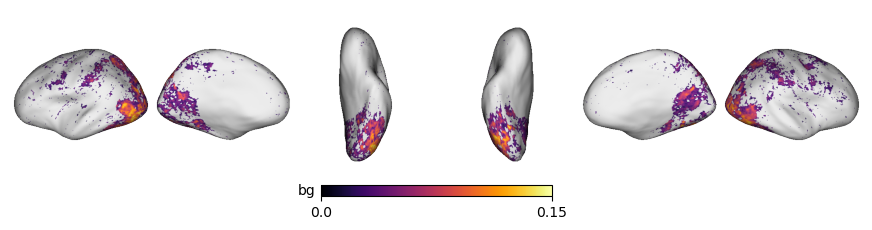

In [32]:
key = 'bg-r'
# bgnib = nib.load(join(gii_dir,f'{key}_align-{alignment}_hemi-lh_ttest.gii'))
bgL = nib.load(f"{gii_dir}/{key}_pca-40_align-{alignment}_hemi-lh_ttest.gii")
bgR = nib.load(f"{gii_dir}/{key}_pca-40_align-{alignment}_hemi-rh_ttest.gii")
print(np.max(bgL.agg_data()))
color_range = (0,.15)
p = Plot(surf_lh=lh, surf_rh=rh, size=(1000, 200), zoom=1.2, layout='row', views=['lateral', 'medial', 'ventral'], 
         mirror_views=True, brightness=.7)
p.add_layer({'left': bgL, 
             'right': bgR}, 
             cmap='inferno', cbar=True,
             color_range=color_range,
             cbar_label='bg'
             ) # YlOrRd_r
cbar_kws = dict(outer_labels_only=True, pad=.02, n_ticks=2, decimals=3)
fig = p.build(cbar_kws=cbar_kws)
fig.show()


0.07760899


/var/folders/sq/9y9jm3711js9zfqyb64n8c840000gn/T/ipykernel_65986/970221840.py:16: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


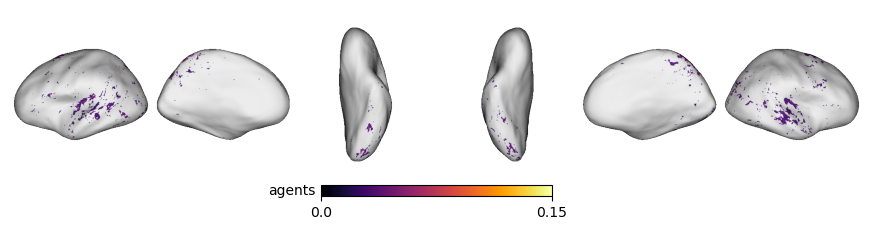

In [33]:
key = 'agents-r'
agentsL = nib.load(f"{gii_dir}/{key}_pca-40_align-{alignment}_hemi-lh_ttest.gii")
agentsR = nib.load(f"{gii_dir}/{key}_pca-40_align-{alignment}_hemi-rh_ttest.gii")
print(np.max(agentsL.agg_data()))
color_range = (0,.15)
p = Plot(surf_lh=lh, surf_rh=rh, size=(1000, 200), zoom=1.2, layout='row', views=['lateral', 'medial', 'ventral'], 
         mirror_views=True, brightness=.7)
p.add_layer({'left': agentsL, 
             'right': agentsR}, 
             cmap='inferno', cbar=True,
             color_range=color_range,
             cbar_label='agents'
             ) # YlOrRd_r
cbar_kws = dict(outer_labels_only=True, pad=.02, n_ticks=2, decimals=3)
fig = p.build(cbar_kws=cbar_kws)
fig.show()


0.12603828


/var/folders/sq/9y9jm3711js9zfqyb64n8c840000gn/T/ipykernel_65986/3200846406.py:16: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


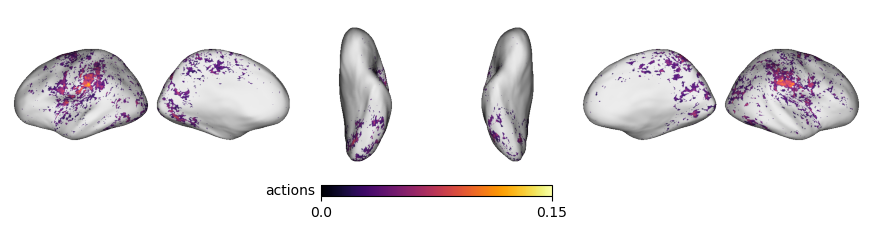

In [35]:
key = 'actions-r'
actionsL = nib.load(f"{gii_dir}/{key}_pca-40_align-{alignment}_hemi-lh_ttest.gii")
actionsR = nib.load(f"{gii_dir}/{key}_pca-40_align-{alignment}_hemi-rh_ttest.gii")
print(np.max(actionsL.agg_data()))
color_range = (0,.15)
p = Plot(surf_lh=lh, surf_rh=rh, size=(1000, 200), zoom=1.2, layout='row', views=['lateral', 'medial', 'ventral'], 
         mirror_views=True, brightness=.7)
p.add_layer({'left': actionsL, 
             'right': actionsR}, 
             cmap='inferno', cbar=True,
             color_range=color_range,
             cbar_label='actions'
             ) # YlOrRd_r
cbar_kws = dict(outer_labels_only=True, pad=.02, n_ticks=2, decimals=3)
fig = p.build(cbar_kws=cbar_kws)
fig.show()

0.23130818


/var/folders/sq/9y9jm3711js9zfqyb64n8c840000gn/T/ipykernel_65986/3357891801.py:16: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


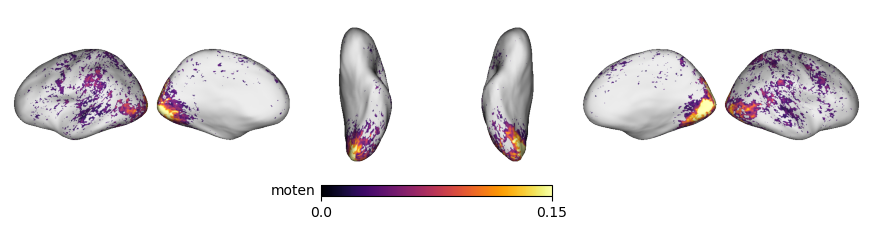

In [36]:
key = 'moten-r'
motenL = nib.load(f"{gii_dir}/{key}_pca-40_align-{alignment}_hemi-lh_ttest.gii")
motenR = nib.load(f"{gii_dir}/{key}_pca-40_align-{alignment}_hemi-rh_ttest.gii")
print(np.max(motenL.agg_data()))
color_range = (0,.15)
p = Plot(surf_lh=lh, surf_rh=rh, size=(1000, 200), zoom=1.2, layout='row', views=['lateral', 'medial', 'ventral'], 
         mirror_views=True, brightness=.7)
p.add_layer({'left': motenL, 
             'right': motenR}, 
             cmap='inferno', cbar=True,
             color_range=color_range,
             cbar_label='moten'
             ) # YlOrRd_r
cbar_kws = dict(outer_labels_only=True, pad=.02, n_ticks=2, decimals=3)
fig = p.build(cbar_kws=cbar_kws)
fig.show()

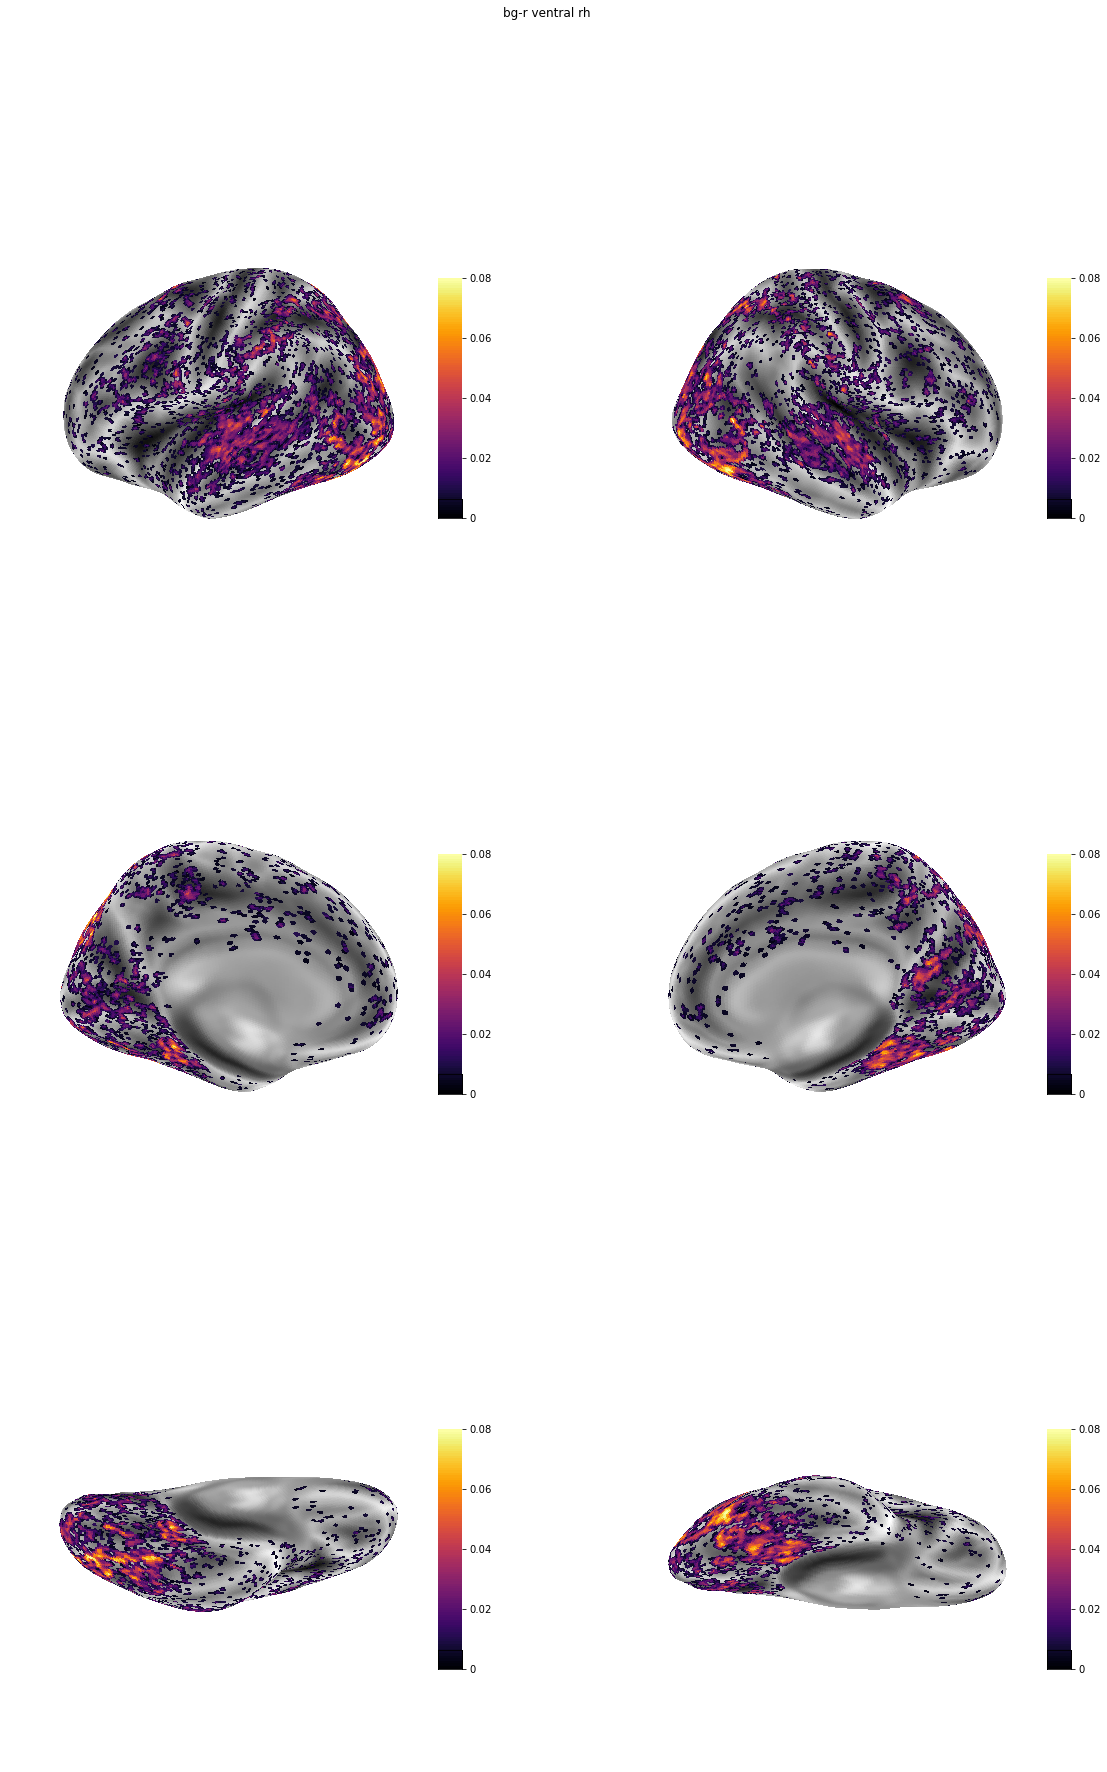

In [47]:
# plot_infl(gii_dir, 'bg-r', plt.cm.inferno, vmax = .08)

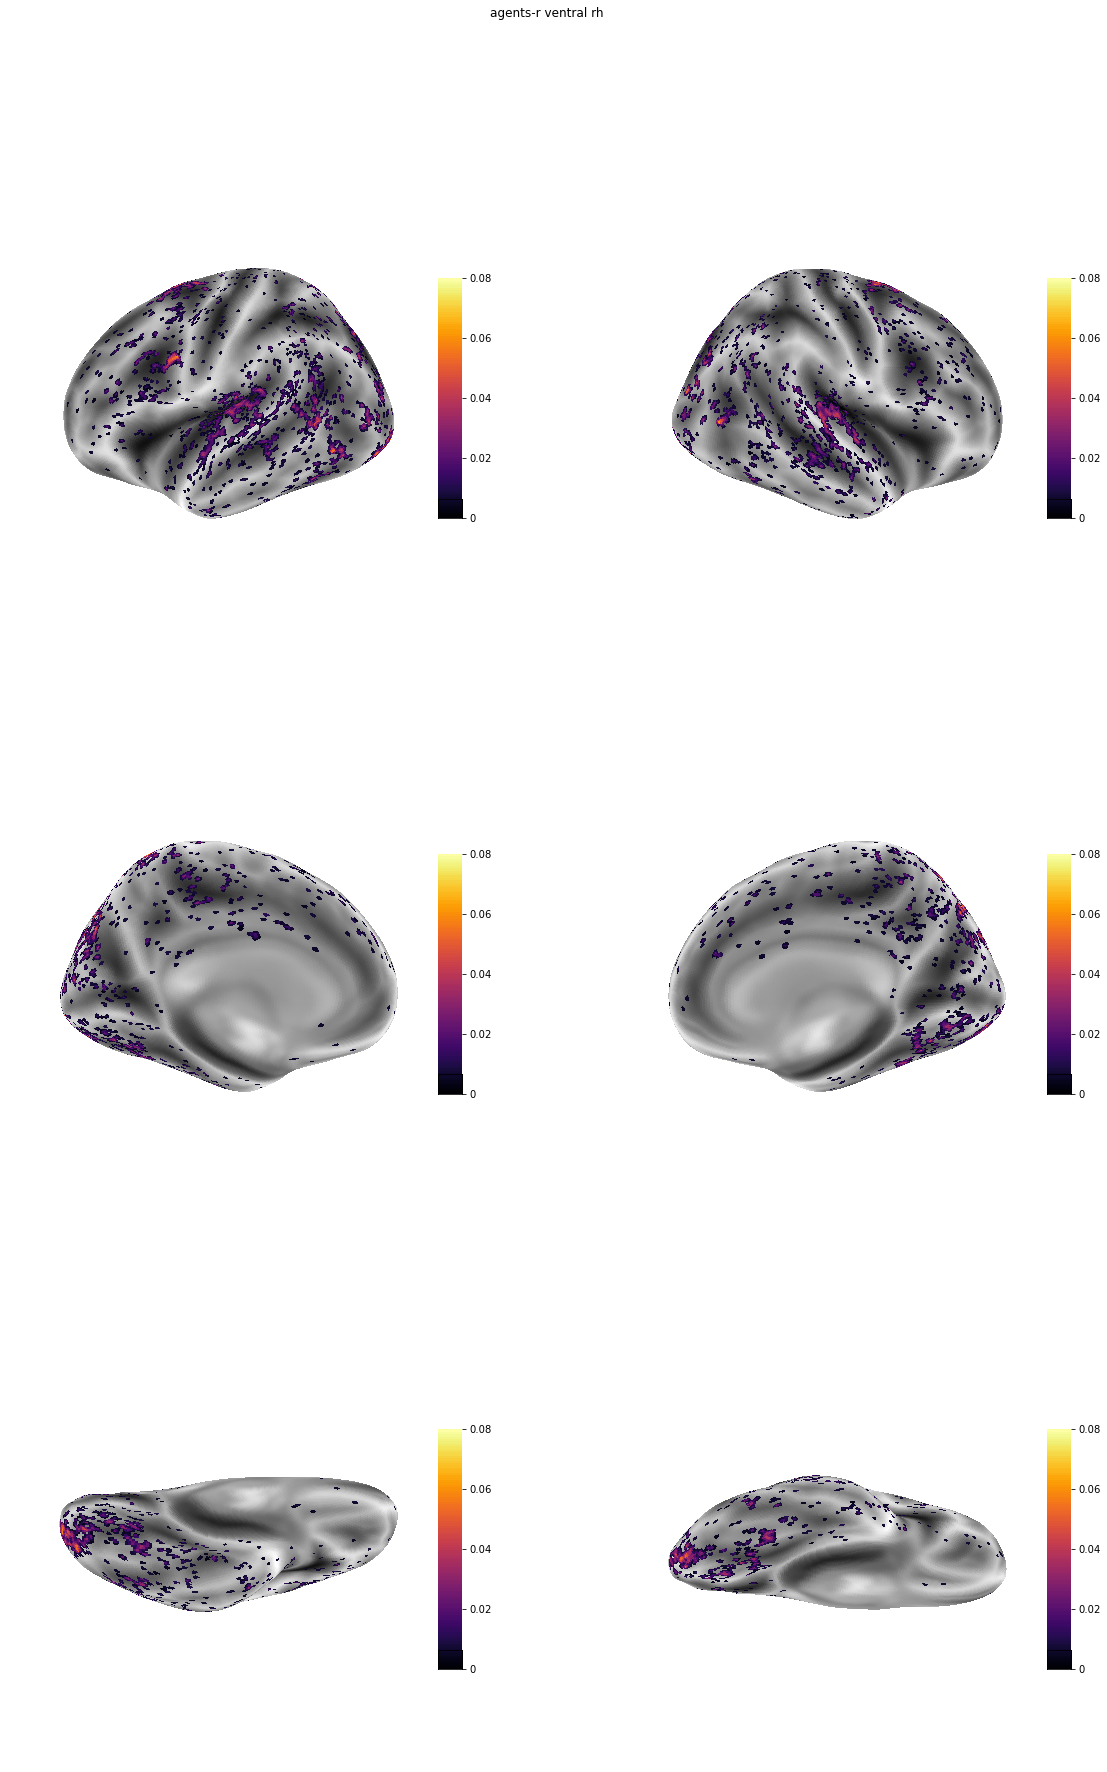

In [48]:
plot_infl(gii_dir, 'agents-r', plt.cm.inferno, vmax = .08)

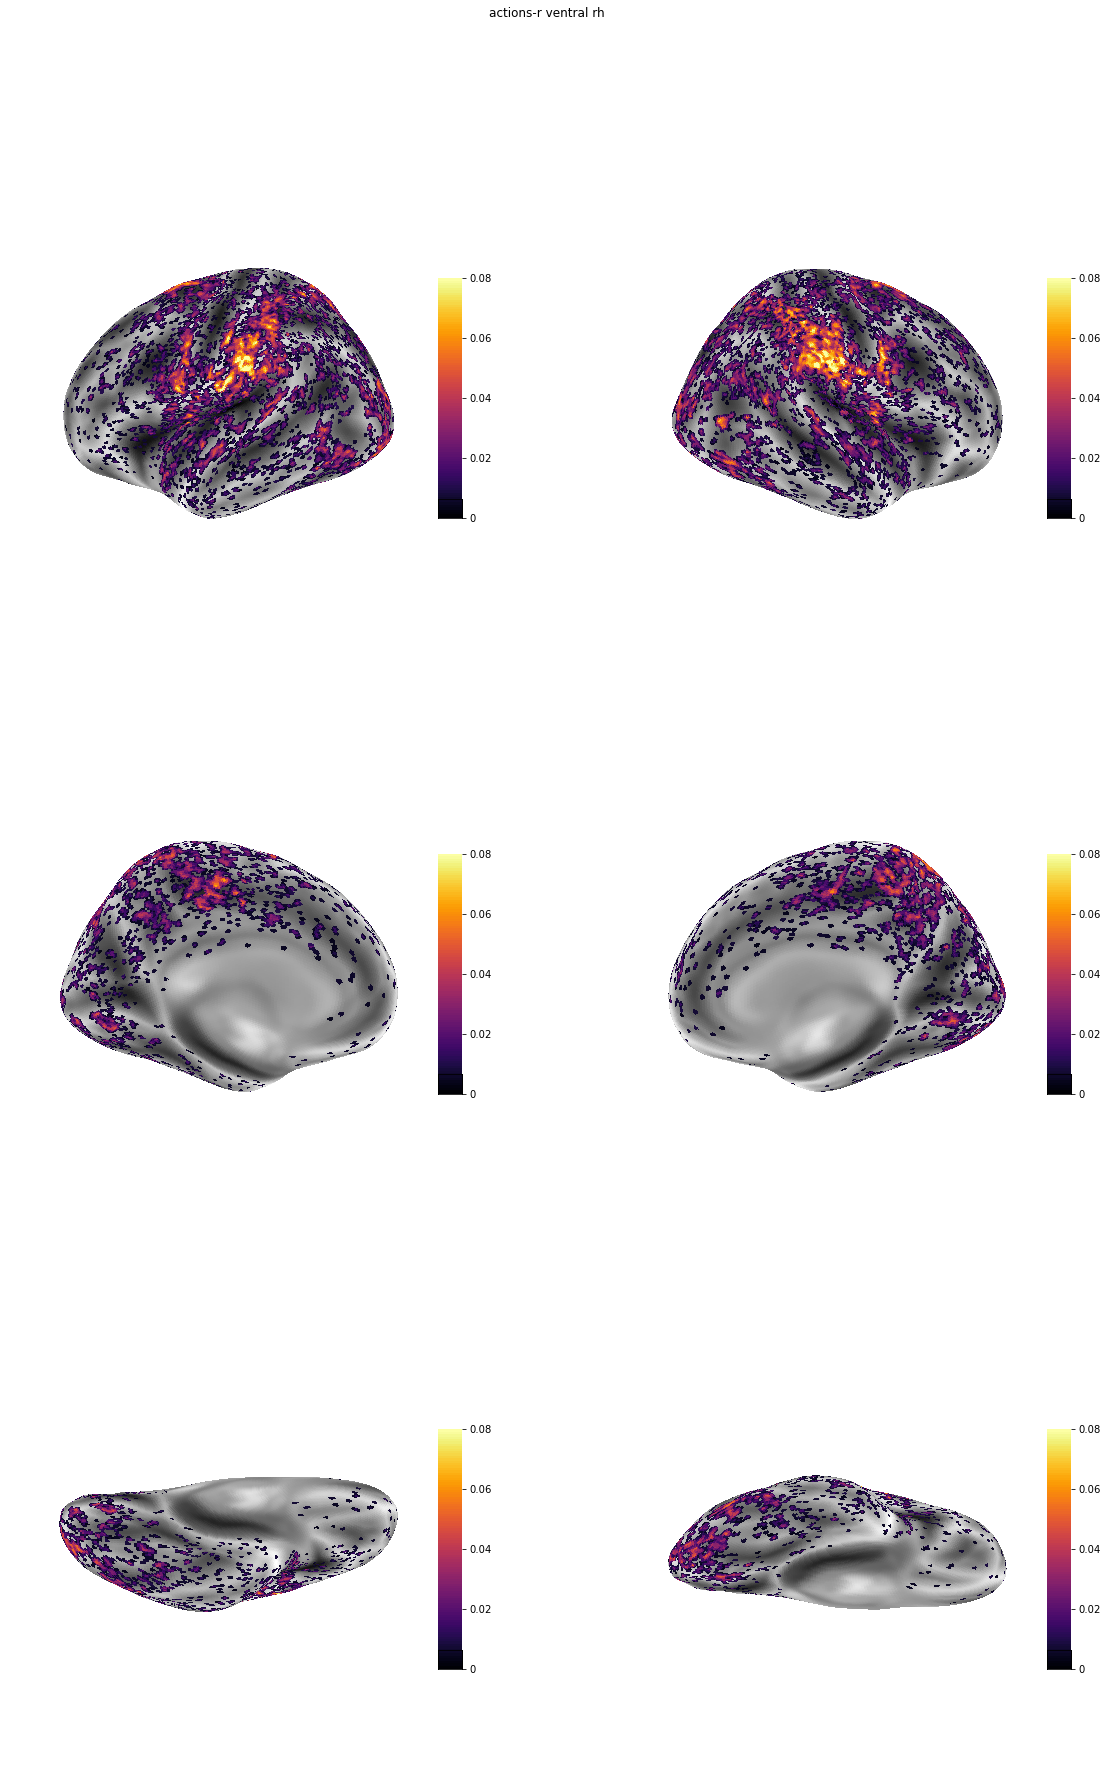

In [49]:
plot_infl(gii_dir, 'actions-r',plt.cm.inferno, vmax = .08)

In [63]:
def plot_infl_diff(gii_dir, key1, key2, cmap, vmax):
    # align = os.path.basename(gii_dir)
    figure, axes = plt.subplots(
        3, 2, subplot_kw={'projection': '3d'}, figsize=(20, 30))

    # double_c = np.vstack((cmap(np.linspace(0, 1, 100)), #
                        # cmap(np.linspace(0, 1, 100))))
    # cmap_convert = colors.ListedColormap(double_c)

    plot_surf_stat_map(fsaverage['infl_left'], join(gii_dir, f'{key1}-{key2}_align-{alignment}_hemi-lh_ttest.gii'),
                       bg_map=fsaverage['sulc_left'],
                       title=f'{key1} > {key2} lateral lh', threshold=1e-10, vmax = vmax,
                       hemi='left', view='lateral', cmap=cmap, axes=axes[0][0], colorbar=True)  # vmin=.05, vmax=.5,
    plot_surf_stat_map(fsaverage['infl_right'], join(gii_dir, f'{key1}-{key2}_align-{alignment}_hemi-rh_ttest.gii'),
                       bg_map=fsaverage['sulc_right'],
                       title=f'{key1} > {key2}  lateral rh', threshold=1e-10, vmax = vmax,
                       hemi='right', view='lateral', cmap=cmap, axes=axes[0][1], colorbar=True)  # vmin=.05, vmax=.5,

    plot_surf_stat_map(fsaverage['infl_left'], join(gii_dir, f'{key1}-{key2}_align-{alignment}_hemi-lh_ttest.gii'),
                       bg_map=fsaverage['sulc_left'],
                       title=f'{key1} > {key2}  medial lh', threshold=1e-10, vmax = vmax,
                       hemi='left', view='medial', cmap=cmap, axes=axes[1][0], colorbar=True)  # vmin=.05, vmax=.5,
    plot_surf_stat_map(fsaverage['infl_right'], join(gii_dir, f'{key1}-{key2}_align-{alignment}_hemi-rh_ttest.gii'),
                       bg_map=fsaverage['sulc_right'],
                       title=f'{key1} > {key2}  medial rh', threshold=1e-10, vmax = vmax,
                       hemi='right', view='medial', cmap=cmap, axes=axes[1][1], colorbar=True)  # vmin=.05, vmax=.5,

    plot_surf_stat_map(fsaverage['infl_left'], join(gii_dir, f'{key1}-{key2}_align-{alignment}_hemi-lh_ttest.gii'),
                       bg_map=fsaverage['sulc_left'],
                       title=f'{key1} > {key2}  ventral lh', threshold=1e-10, vmax = vmax,
                       hemi='left', view='ventral', cmap=cmap, axes=axes[2][0], colorbar=True)  # vmin=.05, vmax,=.5,
    plot_surf_stat_map(fsaverage['infl_right'], join(gii_dir, f'{key1}-{key2}_align-{alignment}_hemi-rh_ttest.gii'),
                       bg_map=fsaverage['sulc_right'],
                       title=f'{key1} > {key2}  ventral rh', threshold=1e-10, vmax = vmax,
                       hemi='right', view='ventral', cmap=cmap, axes=axes[2][1], colorbar=True)  # vmin=.05, vmax=.5,

    plt.show()


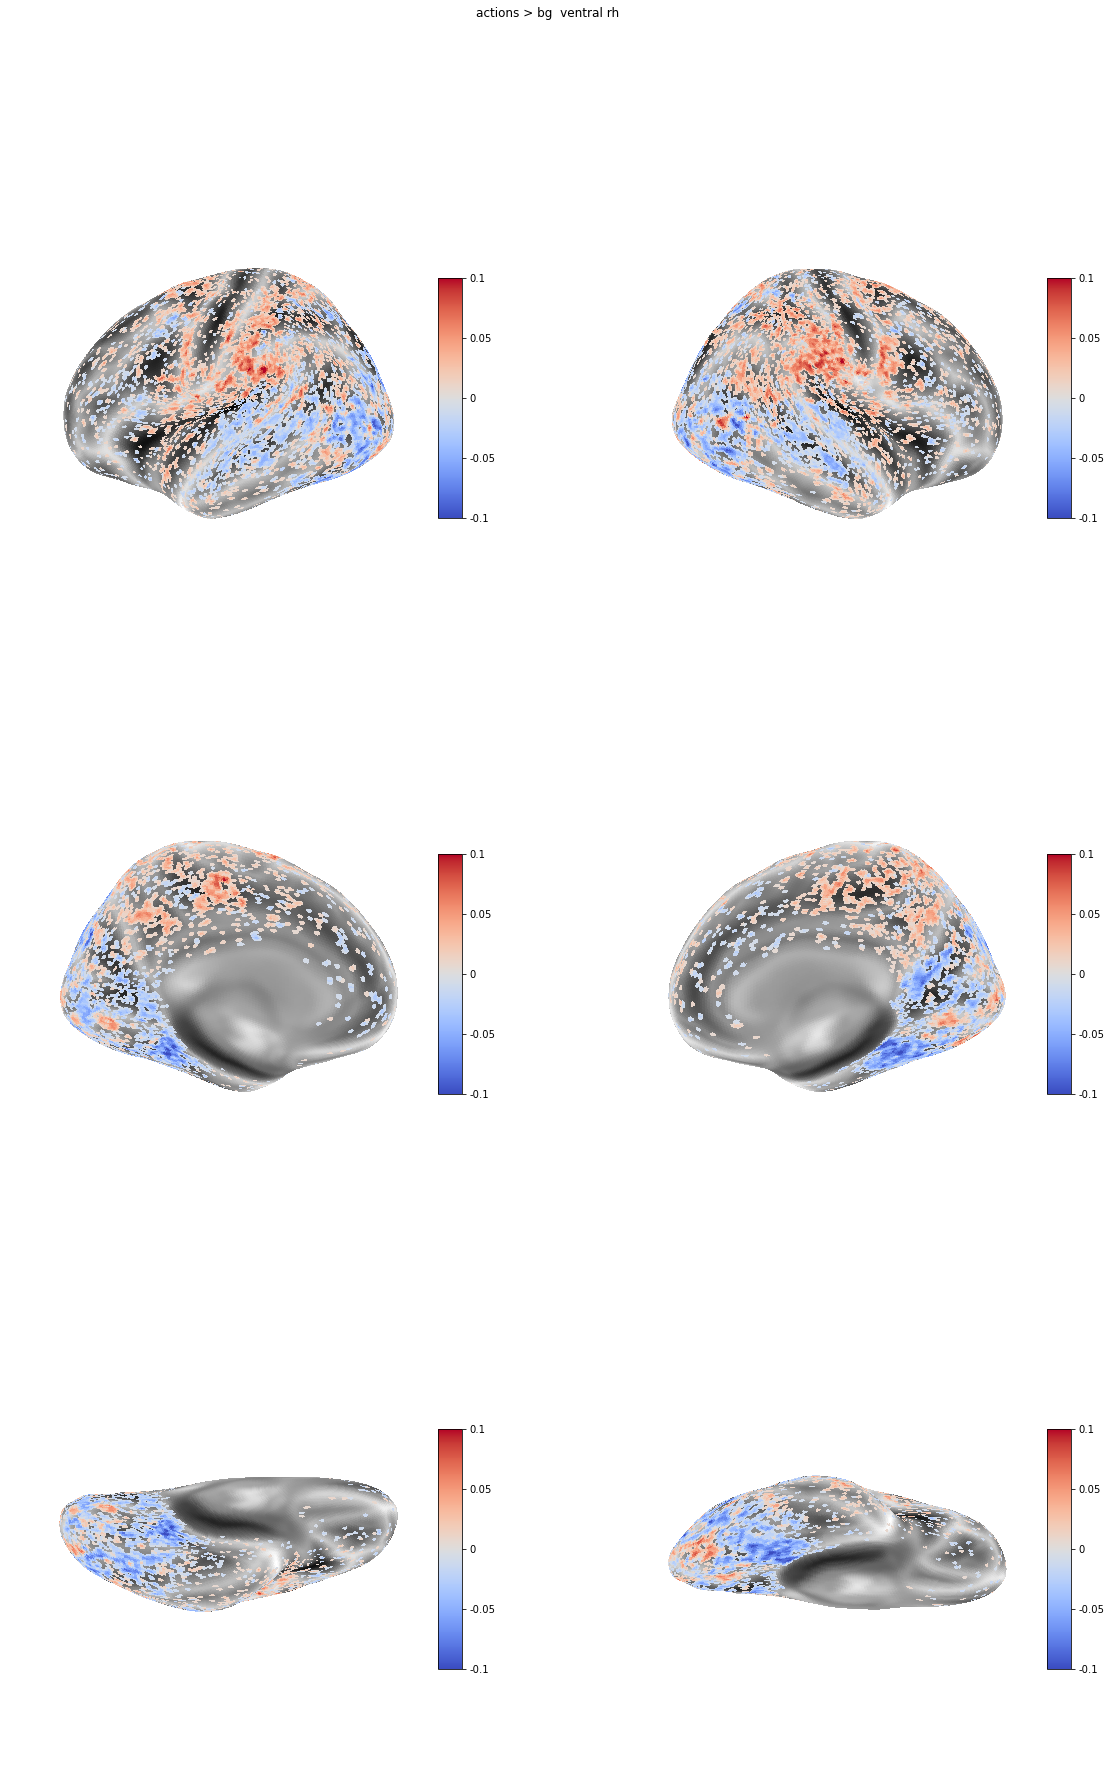

In [64]:
plot_infl_diff(gii_dir, 'actions', 'bg', 'coolwarm', vmax = .1)

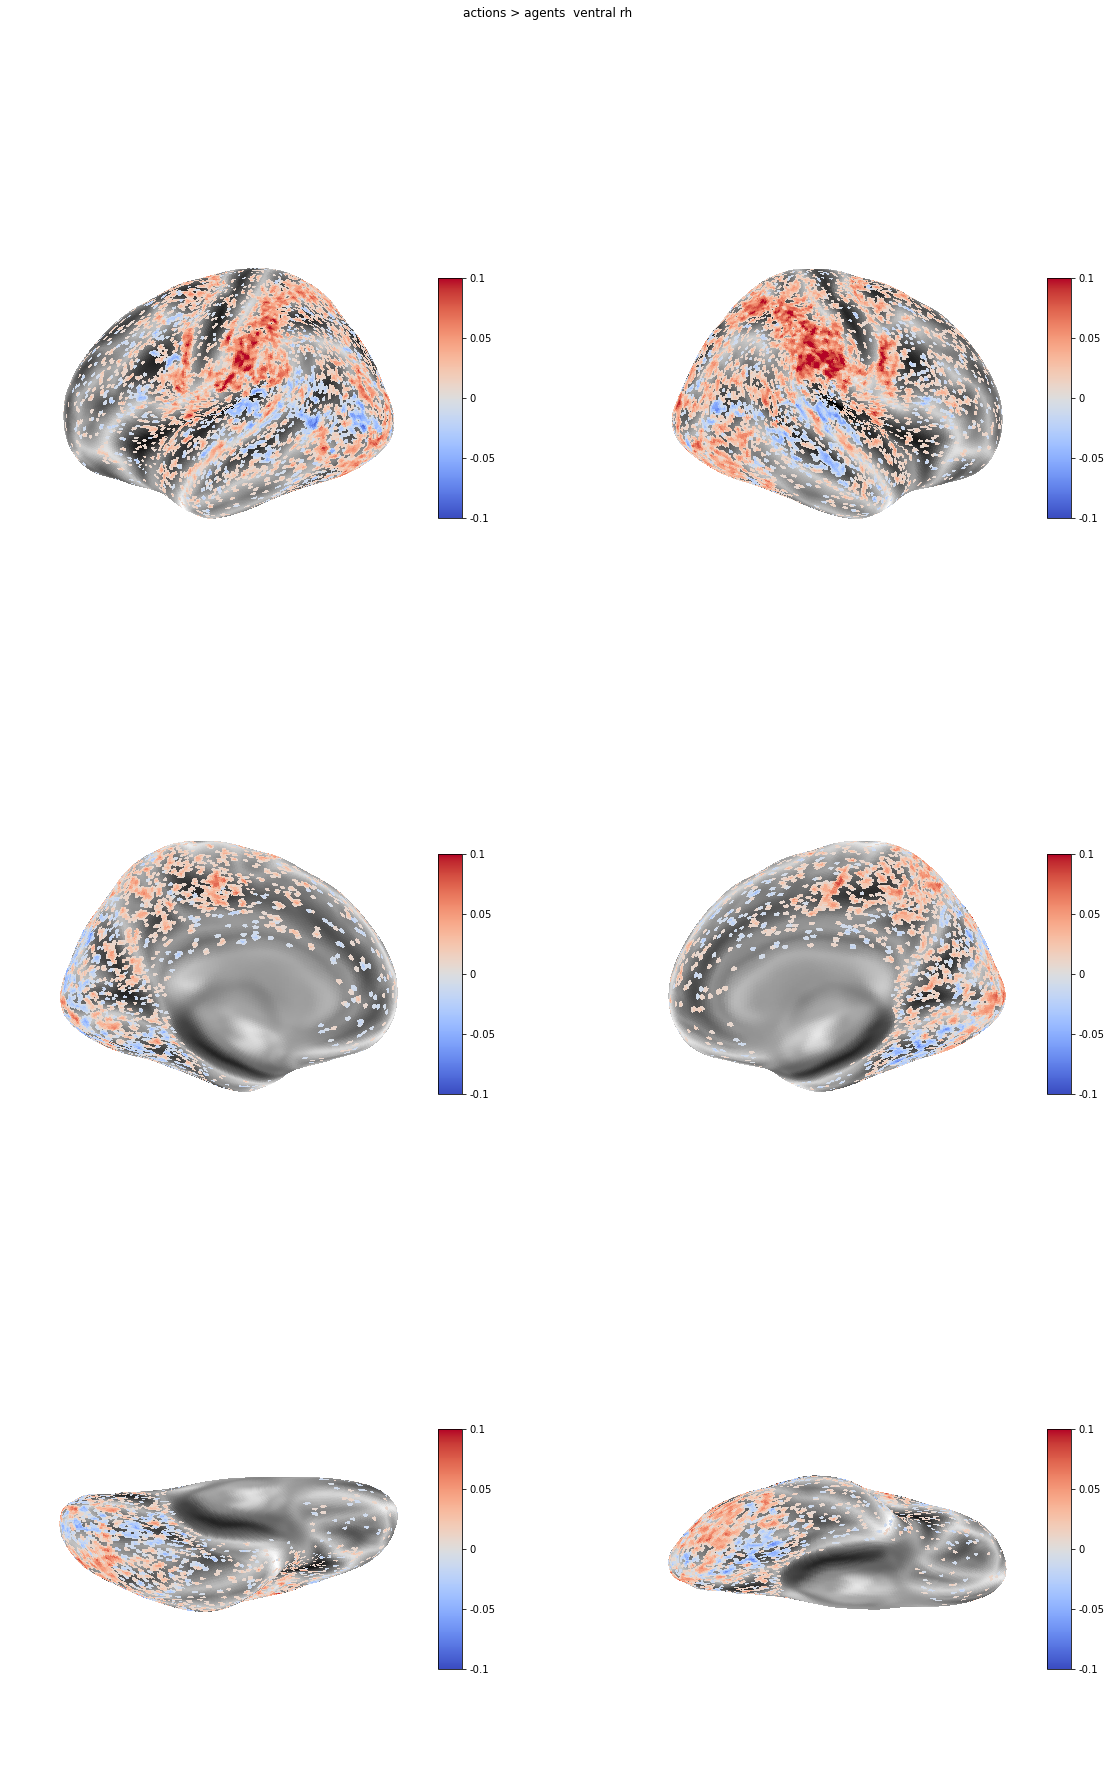

In [65]:
plot_infl_diff(gii_dir, 'actions', 'agents', 'coolwarm', vmax = .1)

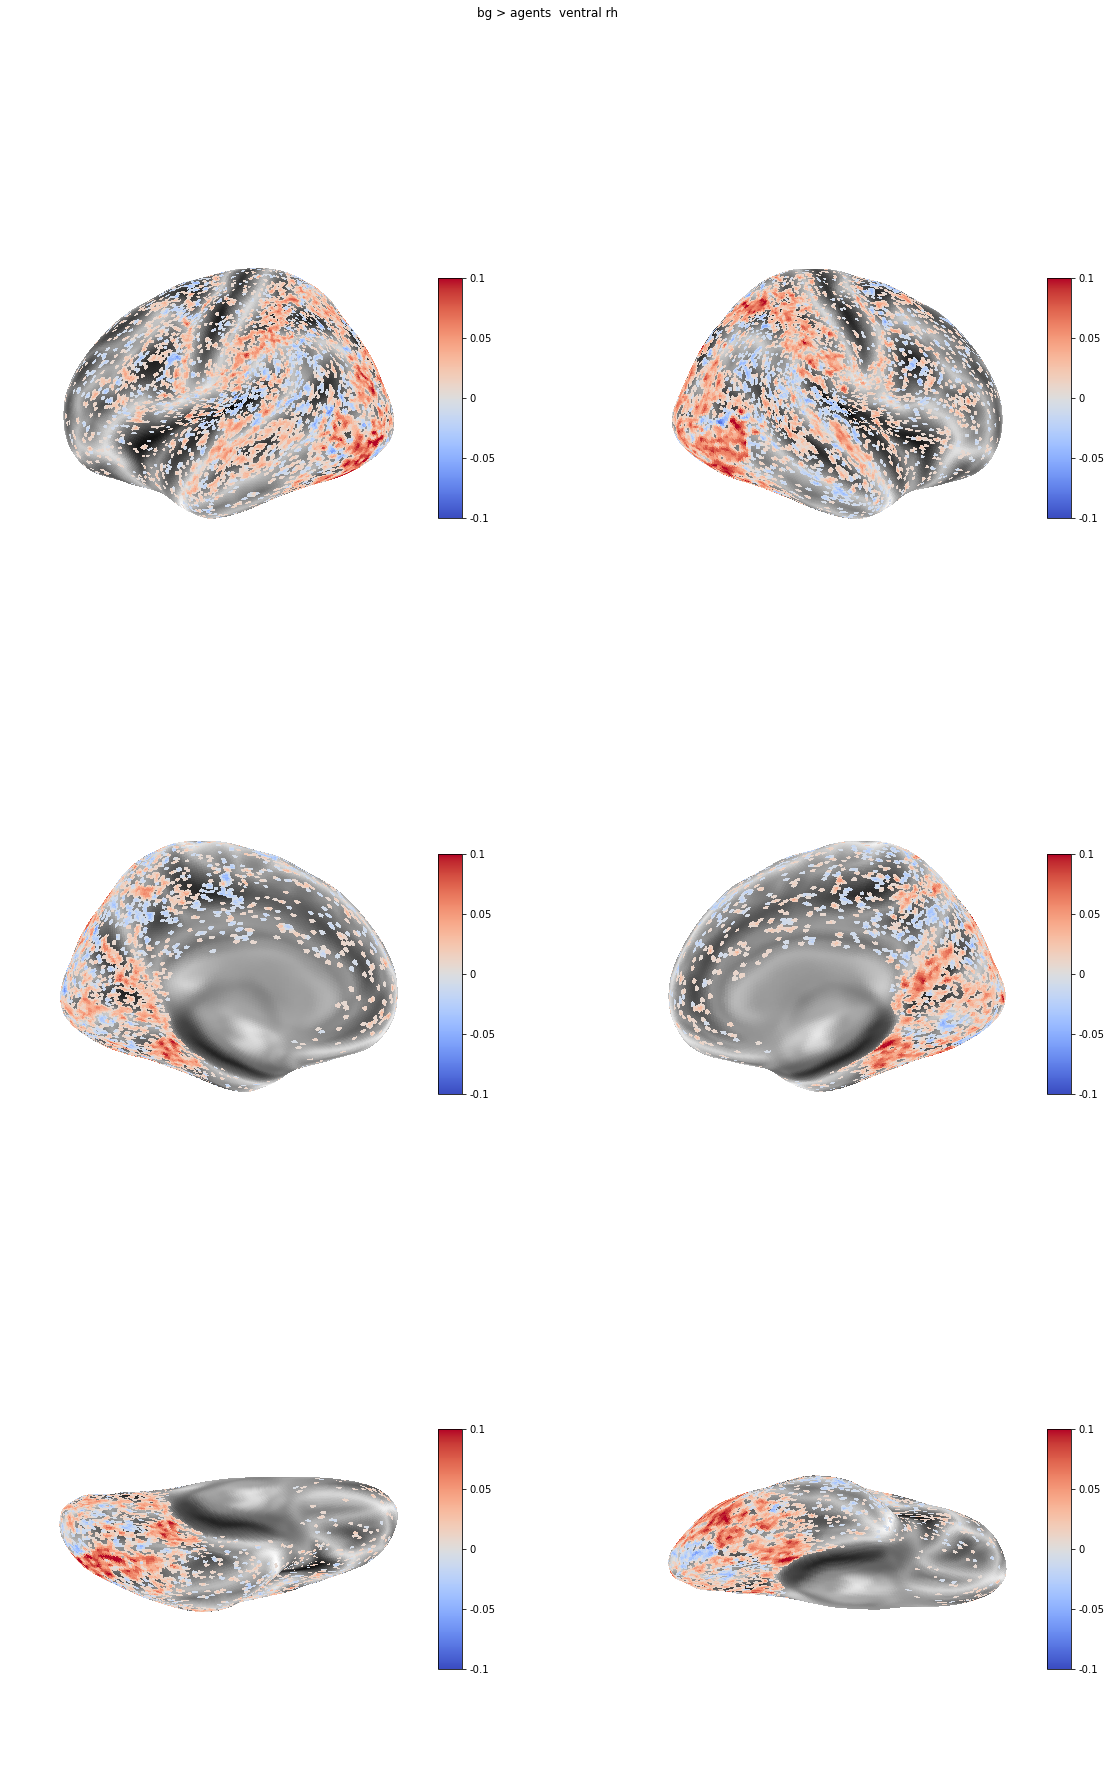

In [66]:
plot_infl_diff(gii_dir, 'bg', 'agents', 'coolwarm', vmax = .1)